# Clustering - Prudential Life

## Importing Packages and loading into DF

In [1]:
from __future__ import print_function
import timeit

from sklearn.model_selection import learning_curve, ShuffleSplit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

import xgboost as xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import sklearn.ensemble
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, mean_squared_error, accuracy_score

import lime
import lime.lime_tabular

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
ins_data = './dataset/train.csv'
ins = pd.read_csv(ins_data)
# ins_test_data = './dataset/test.csv'
# ins_test = pd.read_csv(ins_test_data)

In [3]:
print(ins.shape)
# print(ins_test.shape)

(59381, 128)


## Cleaing Data
- Dropping Axis Column
- Creating dummy for column Product_Info_2 column
- Removing NaN values - where normally distributed, replacing with mean value, where other columns used meadian.

In [4]:
ins.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,3,3,240.0,3,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,3,3,0.0,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


In [5]:
ins.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59362.000000,59381.000000,59381.000000,52602.000000,59381.000000,48527.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,33985.000000,59381.000000,59381.000000,59381.000000,59381.000000,30725.000000,25140.000000,40197.000000,17570.000000,50492.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,557.000000,59381.000000,59381.000000,59381.000000,59381.000000,14785.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,3801.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,1107.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,0.469462,0.077582

In [7]:
ins.drop('Id',axis=1,inplace=True)
# ins_test.drop('Id',axis=1,inplace=True)

In [8]:
ins.Product_Info_2.value_counts()
prod_2 = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'A6':6,'A7':7,'A8':8,'B1':9,'B2':10,'C1':11,'C2':12,
          'C3':13,'C4':14,'D1':15,'D2':16,'D3':17,'D4':18,'E1':19}

ins.replace({"Product_Info_2": prod_2},inplace=True)

In [9]:
for i in range(2,6):
    ins['Family_Hist_%i' % i].fillna(0,inplace=True)
#     ins_test['Family_Hist_%i' % i].fillna(0,inplace=True)

for i in [1,10,15,24,32]:
    ins['Medical_History_%i' % i].fillna(0,inplace=True)
#     ins_test['Medical_History_%i' % i].fillna(0,inplace=True)

for i in [1,4,6]:
    ins['Employment_Info_%i' % i].fillna(0,inplace=True)
#     ins_test['Employment_Info_%i' % i].fillna(0,inplace=True)

ins['Insurance_History_5'].fillna(0,inplace=True)
# ins_test['Insurance_History_5'].fillna(0,inplace=True)

## Creating X and y for modelling

In [10]:
for i in ins.columns:
    if str(ins[i].dtypes) == 'int64':
        ins[i] = ins[i].astype('int8')
    else:
        ins[i] = ins[i].astype('float16')

In [11]:
features = ins.drop(['Response','Ht','Wt'],axis=1)
targets = ins.Response
targets = targets.map(lambda x: x-1)
X, X_holdout, y, y_holdout = train_test_split(features,targets, train_size = 0.8,test_size=0.2,random_state=77)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.9,test_size=0.1,random_state=50)

#### Determining Baseline

In [12]:
y_train.value_counts()

7    14028
5     8069
6     5821
1     4714
0     4489
4     3906
3     1003
2      723
Name: Response, dtype: int64

In [13]:
baseline=15637/len(y_train)
print(baseline)

0.36575211096297333


## PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=5,random_state=999)
principal_components = pca.fit_transform(ins.drop('Response',axis=1))
principleDF = pd.DataFrame(data= principal_components, columns =['PC1','PC2','PC3','PC4',
                                                                'PC5'])

In [16]:
## joining the principle components back with the target "Response"
finalDf = pd.concat([principleDF, ins[['Response']]], axis = 1)

In [17]:
finalDf.head()

,PC1,PC2,PC3,PC4,PC5,Response
0,128.015232,196.126044,-16.422340,-1.927657,-3.487177,8
1,-108.044805,-19.634114,-1.747350,0.299454,-0.517554,4
2,-5.598955,-30.573108,-1.548477,0.116285,3.242626,8
3,84.741867,-40.149729,-1.625207,-0.038421,-8.195901,8
4,-102.191604,-20.282124,-1.732326,0.145062,-5.299215,8


C:\Users\Roy\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


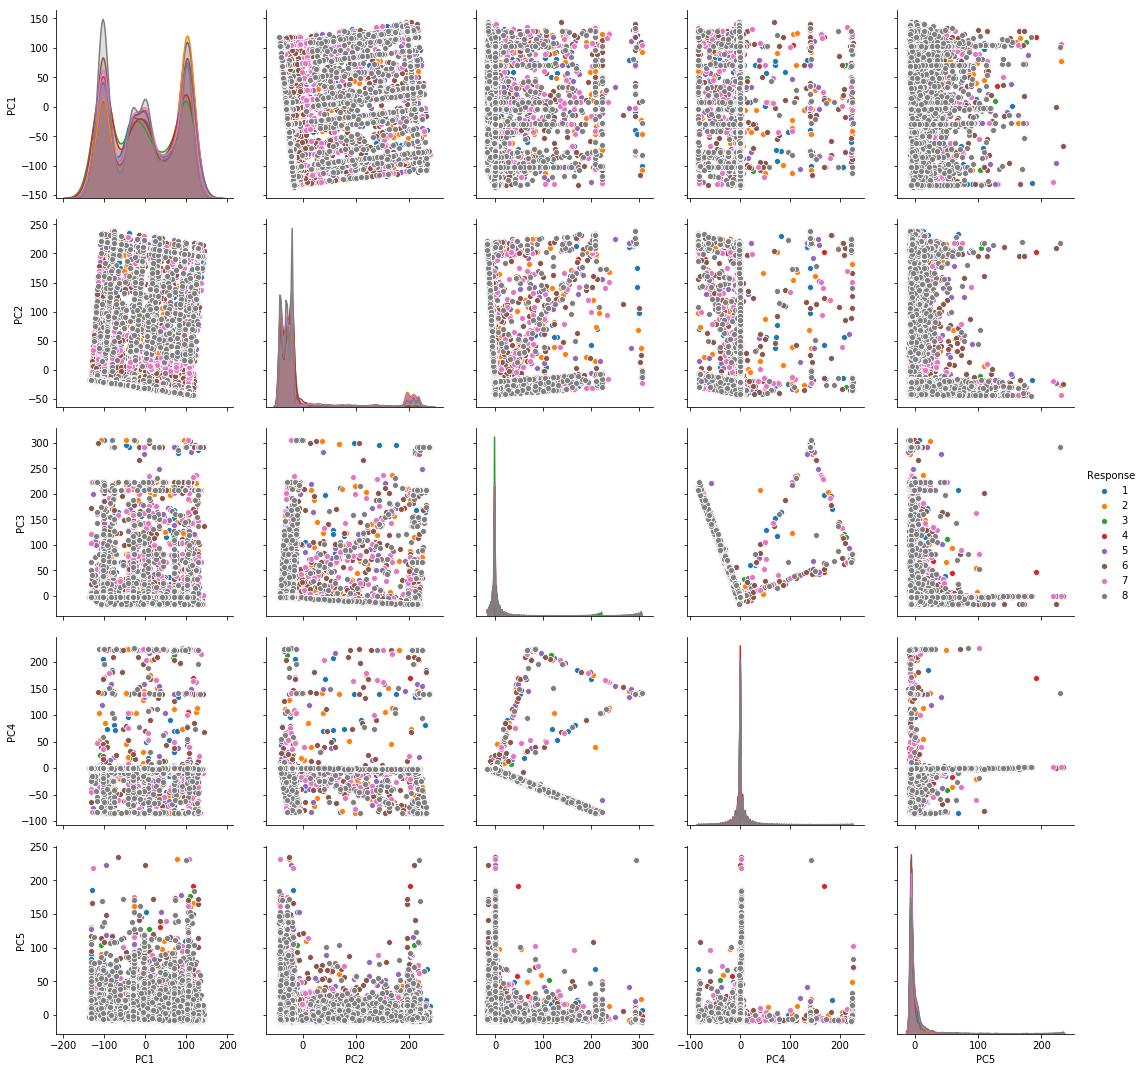

In [20]:
## scatter plot to see if we have any clearly identifiable groups using target as hue.
sns.pairplot(data=finalDf, vars=['PC1','PC2','PC3','PC4','PC5'], hue='Response', size=3);

## Clustering - K Means

In [21]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=8)
k_means.fit(principleDF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
## creating array for new groups from clustering to join back into our dataframe.
labels = k_means.labels_
labels

array([3, 1, 4, ..., 1, 2, 1])

In [24]:
finalDf['cluster_result'] = labels

#### Measures taken comparing clusters to the Ground Truth.

In [34]:
from sklearn.metrics import silhouette_score

print("Silhouette Score: ", round(silhouette_score(principleDF, labels),2))

Silhouette Score:  0.59


In [26]:
from sklearn.metrics import homogeneity_score

In [37]:
print("Homogeneity Score: ", round(homogeneity_score(finalDf['Response'],finalDf['cluster_result']),2))

Homogeneity Score:  0.01


In [38]:
from sklearn.metrics import completeness_score
print("Completeness Score: ",round(completeness_score(finalDf['Response'],finalDf['cluster_result']),2))

Completeness Score:  0.01


In [30]:
from sklearn.metrics import v_measure_score

In [39]:
print("V Measure Score: ", round(v_measure_score(finalDf['Response'],finalDf['cluster_result']),2))

V Measure Score:  0.01
